# Проект DonorSearch Reports Rotation

### Введение
Заказчик - DonorSearch -  занимается развитием донорства в стране. Для этого есть платформа DonorSearch.org - где для доноров доступны бонусная программа, игрофикация пути донора и многое другое. Важной является проверка честности доноров и корректности внесенных донаций. Подтверждение производится по справке установленной формы (№405), такую справку донор получает в центре крови.

### Задачи проекта
- Исследовать существующие подходы к решению задачи;
- Выбор готовой или обучение собственной модели компьютерного зрения для определения ориентации изображения;
- Подготовка скриптов для препроцессинга изображения, инференса модели и постпроцессинга изображения;
- Тестирование модели, определение метрик;
- Создание микросервиса для последующей интеграции в продукт заказчика.


### Исходные данные
Набор изображений в разной ориентации. Имеются целевые фотографии справок, а так же дополнительные.


### Требования

- Рассчитана Accuracy для многоклассовой классификации;
- Построены ROC-кривые и матрицы ошибок для наилучшей из моделей;
- Формат входных данных - путь к изображению;
- Формат выходных данных - np.array или Pillow.Image (либи любой другой вариант, итоговый вариант озвучит заказчик);
- Количество классов классификатора - 4 (поворот на 0, 90, 180 или 270 градусов);
- Инференс - на CPU.

## Исследование подходов к решению задачи

Задача — автоматически определять угол поворота изображения (0°, 90°, 180°, 270°) и корректировать ориентацию перед следующим шагом в продекте заказчика. Основные подходы по определению ориентации:

### Традиционные методы компьютерного зрения

**SIFT, SURF, ORB (фичерные методы)**
- Методы извлечения ключевых точек могут использоваться для нахождения повторяющихся элементов на изображении. Это подходит, если на справке присутствуют узнаваемые символы или логотипы, которые помогут определить правильное положение.
- Преимущества: простота и относительная скорость выполнения.
- Недостатки: чувствительность к качеству изображения, шумам и деформациям.

**Hough Transform**
- Преобразование Хафа часто используется для поиска линий и углов. Можно использовать для обнаружения горизонтальных и вертикальных линий на документе и корректировки его ориентации.
- Преимущества: устойчивость к шумам.
- Недостатки: сложно применить к сложным документам или документам с множеством элементов.

### Методы, основанные на глубоких нейронных сетях (DNN)

**ResNet, EfficientNet, Vision Transformer (ViT)**
- Современные глубокие сети могут быть обучены для предсказания угла поворота изображения. Можно настроить модель на классификацию углов поворота (0°, 90°, 180°, 270°).
- Преимущества: высокое качество предсказаний на сложных данных, возможность использования предобученных моделей.
- Недостатки: требуется большой объем данных для обучения, высокая вычислительная стоимость.

### Предобученные модели глубоких нейронных сетей с дообучением на исходных данных

- Использование предобученных моделей, таких как ResNet, EfficientNet, ViT, может значительно ускорить процесс разработки. Если доступны датасеты с подобными медицинскими справками, они могут быть использованы для дообучения.
- Преимущества: меньшие затраты на обучение, более быстрое внедрение.
- Недостатки: могут быть не адаптированы под специфические задачи и данные.

### Способ повысить производительность

**Аугментация изображений**

Для повышения производительности модели можно использовать:

- Повороты на случайные углы.
- Изменения яркости, контраста, шума (чтобы имитировать разные условия съемки справок).
- Кроппинг и масштабирование изображений.

**Вывод:**
Для решения поставленной задачи будет использована комбинация методов глубокого обучения с предобученными моделями, такими как ResNet или EfficientNet, с применением аугментации. Это обеспечит высокую точность в условиях ограниченного объема данных и разнообразных изображений справок.

## Подготовка данных

Загружаем необходимые библиотеки

In [1]:
# Стандартные библиотеки
import time
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle

# Вспомогательные библиотеки
from tqdm import tqdm
from PIL import Image

# Библиотеки для оценки метрик sklearn
from sklearn.metrics import (confusion_matrix, roc_curve, auc,
                             precision_recall_curve,
                             average_precision_score)
from sklearn.preprocessing import label_binarize



# Библиотеки глубокого обучения нейросетей
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2
from torchvision import models
from torchvision.datasets import ImageFolder

# Исходные константы
# Классы поворота: 0, 90, 180, 270 градусов
NUM_CLASSES = 4
# Директория с изображениями
IMAGE_DIR = 'src/data/image/transformed'
# Размер пачки тензоров
BATCH_SIZE = 32

Исходные изображения состоят из фотографий целевых и нецелевых справок. В проекте не стоит задача определения целевой справки. Для обучения определения ориентации изображения подойдут любые справки. 

Так как количество изображений ограничено 173 единицами, принято решение все изображения привести к нормальной ориентации и аугментировать поворотом на 90, 180 и 270 градусов. Таким образом количество изображений увеличится в 4 раза, что все равно недостаточно для качественного обучения нейронной сети. Для поворота изображений используем следующую функцию.

In [2]:
# Подготовка данных с поворотами
def prepare_rotated_dataset(image_dir: str, need_create: bool) -> str:
    """
    Подготавливает набор данных с изображениями, повернутыми на различные углы, и сохраняет их в отдельные папки по классам.

    :param image_dir: str
        Путь к директории с исходными изображениями, которые будут поворачиваться.
    
    :return: str
        Путь к директории, содержащей папки с повернутыми изображениями, где каждая папка соответствует углу поворота (0°, 90°, 180°, 270°).
    
    Описание:
    1. Создает директорию 'transformed' внутри исходной директории для хранения повернутых изображений.
    2. Для каждого угла поворота (0°, 90°, 180°, 270°) создает отдельную папку.
    3. Перебирает все изображения в исходной директории (с расширениями .jpg и .png).
    4. Выполняет поворот изображения на указанный угол и сохраняет его в соответствующей папке.
    
    Классы поворотов:
    - 0: Нет поворота (0°).
    - 1: Поворот на 90°.
    - 2: Поворот на 180°.
    - 3: Поворот на 270°.

    Пример использования:
    ```
    prepare_rotated_dataset('/path/to/images')
    ```
    """    

    transformed_dir = os.path.join(image_dir, 'transformed')

    if not need_create:
        return "Images transformed yet"
    
    os.makedirs(transformed_dir, exist_ok=True)

    classes = [0, 1, 2, 3]  # 0 - нет поворота, 1 - 90 градусов, 2 - 180 градусов, 3 - 270 градусов
    angles = [0, 90, 180, 270]

    for class_id, angle in zip(classes, angles):
        class_dir = os.path.join(transformed_dir, str(class_id))
        os.makedirs(class_dir, exist_ok=True)
        for filename in os.listdir(image_dir):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                img_path = os.path.join(image_dir, filename)
                img = Image.open(img_path)
                rotated_img = rotate_image(img, angle)
                rotated_img.save(os.path.join(class_dir, f'{class_id}_{filename}'))

    return transformed_dir

# Преобразование изображений с поворотом
def rotate_image(image, angle):
    return image.rotate(angle)

In [3]:
prepare_rotated_dataset(IMAGE_DIR, need_create=False)

'Images transformed yet'

Для корректной загрузки данных в модель необходимо выполнить подготовку изображений. В модель поступают данные в виде тензоров. Модель легко работает с "пачкой" тензоров. 

Во время подготовки необходимо учитывать, что изображения для тренировки должны быть предобработанны аналогично как и тестовые.

Библиотека torch позволяет аугменитровать изображения на этапе трансформации. Например, можно добавить случайный поворот изображения на +-15 градусов и горизонтальное отражение. Так же имеется возможность изменение цвета, гауссовское размытие, изменение размера и тд, но данные изменения не носят случайный характер.

In [4]:
# Определяем трансформации для предобработки
train_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.RandomRotation(degrees=(-15, 15)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.Resize((224, 224)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Для удобства загрузки изображений воспользуемся DataLoader. Он разделит датасет на пачки и перемешает изображения.

In [5]:
# Загрузка подготовленных данных в формате ImageFolder
dataset = ImageFolder(root=IMAGE_DIR, transform=train_transforms)

# Разделение на тренировочные, валидационные и тестовые данные 
train_size = int(0.7 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

**Вывод:**
Подготовлены изображения для обучения, каждый класс находится в своей папке. Все изображения проходят предварительную трансформацию в пачку тензоров. Для удобства подачи тензоров в модель используется DataLoader. 
На каждой эпохе происходит случайное изменение угла поворота изображения на 15 градусов и случайное отражение по вертикали. Такой подход позволит "на лету" полочить дополнительную аугментацию изображений, что улучшит обучение моделей.

### Подготовка скриптов для моделей

Кратко про используемые в проекте нейронные сети:

1. **ResNet (ResNet18 и ResNet34)**

ResNet (Residual Networks) были предложены исследователями Microsoft Research и сделали революцию в области глубокого обучения, когда речь заходит о тренировке очень глубоких нейронных сетей. Главная особенность ResNet — это остаточные соединения, которые помогают избежать проблемы исчезающего градиента и позволяют эффективно обучать сети с очень большим количеством слоев.

ResNet18: модель с 18 слоями. Это легкая и быстрая модель, которая может быть полезна для небольших или менее сложных задач, таких как предсказание ориентации. Она требует меньше вычислительных ресурсов и может быть использована для быстрой тренировки или предсказания на устройствах с ограниченными ресурсами.

ResNet34: модель с 34 слоями. Она обладает большей глубиной по сравнению с ResNet18 и может извлекать более сложные признаки с изображений. Эта модель обычно используется для более точных прогнозов и в ситуациях, когда требуется повысить производительность за счет более сложных паттернов в данных.

Преимущества ResNet:

- Эффективна на более глубоких сетях благодаря residual connections.
- Хорошо подходит для различных задач классификации изображений.
- Легко дообучаема на небольших наборах данных.

2. **EfficientNet_B0**

EfficientNet — это семейство моделей, представленное в 2019 году компанией Google. Эти модели известны своим сбалансированным подходом к увеличению точности при минимизации вычислительных ресурсов. EfficientNet_B0 — это базовая версия EfficientNet, которая использует инновационный подход к масштабированию глубины, ширины и разрешения сети.

Особенности EfficientNet:

- Комплексное масштабирование: В большинстве моделей увеличение производительности достигается за счет увеличения либо глубины (больше слоев), либо ширины (больше каналов), либо разрешения входного изображения. EfficientNet использует новый подход — compound scaling — который позволяет эффективно масштабировать все три аспекта (глубина, ширина и разрешение) одновременно, что помогает сохранить баланс между сложностью модели и точностью предсказаний.

- Базовая архитектура: EfficientNet использует блоки Inverted Bottleneck, вдохновленные MobileNetV2, и расширяет их с использованием слоев сверток с групповыми нормализациями. Это делает модель легкой и быстрой, но при этом достаточно мощной для сложных задач.

- Эффективность: По сравнению с ResNet и другими архитектурами, EfficientNet достигает лучшей точности при меньшем количестве параметров и операциях с плавающей точкой. Это делает модель особенно привлекательной для мобильных и встроенных устройств, где ресурсы ограничены.

3. **MobileNet V3**


MobileNet V3 — это улучшение предыдущих версий MobileNet (V1 и V2) и использует несколько инноваций для повышения эффективности:

- Свертки с разделением на глубину (depthwise separable convolutions) — разбиение стандартной свертки на две: глубинную свертку и точечную свертку (pointwise), что значительно уменьшает количество параметров и операций.
- Squeeze-and-Excitation (SE) блоки — эти блоки динамически взвешивают каналы, усиливая важные и подавляя несущественные.
- Non-linear Activation Function (h-swish) — активационная функция h-swish (hard swish) заменяет стандартную ReLU для повышения эффективности.
- Light-weight Attention — attention-механизмы для улучшения производительности.

Плюсы:

- Высокая эффективность для мобильных устройств: Благодаря упрощенной архитектуре, MobileNet V3 идеально подходит для использования в приложениях с ограниченными вычислительными ресурсами.
- Низкое потребление памяти: Модель требует меньших объемов памяти, что особенно важно для устройств с малым объемом RAM.
- Оптимизация под устройства: Прекрасно работает на мобильных устройствах благодаря глубокой оптимизации под ARM-архитектуру.
- Высокая производительность при малом количестве параметров: MobileNet V3 поддерживает разумный баланс между количеством параметров и качеством предсказаний.

Минусы:

- Ограниченная производительность на сложных задачах: В случае задач с высокими требованиями к точности MobileNet V3 может уступать более мощным моделям, таким как EfficientNet.
- Меньше возможностей для масштабирования: Ограничена масштабируемость модели, поскольку она ориентирована на мобильные и легкие применения.


4. **ShuffleNet V2**

ShuffleNet V2 предложен как оптимизация предыдущей версии и включает ключевые принципы для повышения эффективности:

- Channel Shuffle — основная инновация архитектуры заключается в смешивании каналов между группами после групповой свертки, что позволяет улучшить взаимодействие информации между каналами;
- Grouped Convolutions — с использованием групповой свертки для уменьшения вычислительной сложности, разделяя фильтры на группы;
- Balanced Computation — архитектура разработана так, чтобы обеспечить баланс вычислительной нагрузки между различными слоями.

Плюсы:

- Высокая скорость вычислений: ShuffleNet V2 обладает очень низкой вычислительной сложностью, что делает его подходящим для реального времени и мобильных приложений.
- Эффективное использование ресурсов: Модель сбалансирована для оптимального использования памяти и вычислительных мощностей.
- Хорошая производительность при низкой сложности: Несмотря на простоту архитектуры, модель демонстрирует хорошую производительность на задачах классификации изображений.

Минусы:

- Потеря точности при слишком малом числе параметров: При значительном уменьшении параметров может пострадать качество предсказаний.
- Меньшая гибкость: Модель менее гибкая и масштабируемая по сравнению с такими архитектурами, как ResNet и EfficientNet.


**Заключение:**
- ResNet18 — легкая и быстрая популярная модель для задач компьютерного зрения, хорошо подходит для базовых классификационных задач с небольшими ресурсами;
- ResNet34 — более тяжелая модель семейства ResNet с увеличенной глубиной, что позволяет достигать более высокой точности при классификации;
- EfficientNet_B0 — эффективная альтернатива ResNet, оптимизированная для хороших результатов на слабых ресурсах за счет использования масштабируемой архитектуры;
- MobileNet V3 — прекрасно подходит для мобильных устройств благодаря глубокой оптимизации под ARM-архитектуру, сохраняя баланс между точностью и эффективностью;
- ShuffleNet V2 — легкая модель, использующая принципы Channel Shuffle и Grouped Convolutions, отлично подходит для встроенных систем и мобильных приложений.


Так как в ТЗ не указано, на каком типе устройства производить обучение, выполним на имеющемся GPU. Таким образом, можно ускорить инференс моделей в 6-10 раз. Настроим устройство.

In [6]:
# Настройки устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

cuda
NVIDIA GeForce GTX 1650


Загрузим каждую из моделей и поменяем последний слой для предсказания 4 классов.

In [7]:
def get_resnet18_model(num_classes: int=NUM_CLASSES) -> torch.nn.Module:
    """
    Создает и возвращает модель ResNet18 с предобученными весами на ImageNet и измененным выходным слоем.

    :param num_classes: int - количество классов для классификации (по умолчанию NUM_CLASSES).
    
    :return: torch.nn.Module - модель ResNet18 с измененным последним слоем под необходимое количество классов.
    """

    model = models.resnet18(weights='IMAGENET1K_V1')  # Загрузка предобученной ResNet34
    model.fc = nn.Linear(model.fc.in_features, num_classes)  # Замена последнего слоя
    print('Model resnet18 ready!')
    return model.to(device)


def get_resnet34_model(num_classes: int=NUM_CLASSES) -> torch.nn.Module:
    """
    Создает и возвращает модель ResNet34 с предобученными весами на ImageNet и измененным выходным слоем.

    :param num_classes: int - количество классов для классификации (по умолчанию NUM_CLASSES).
    
    :return: torch.nn.Module - модель ResNet34 с измененным последним слоем под необходимое количество классов.
    """

    model = models.resnet34(weights='IMAGENET1K_V1')  # Загрузка предобученной ResNet34
    model.fc = nn.Linear(model.fc.in_features, num_classes)  # Замена последнего слоя
    print('Model resnet34 ready!')
    return model.to(device)


def get_efficientnet_model(num_classes: int=NUM_CLASSES) -> torch.nn.Module:
    """
    Создает и возвращает модель EfficientNet-B0 с предобученными весами и измененным выходным классификатором.

    :param num_classes: int - количество классов для классификации (по умолчанию NUM_CLASSES).
    
    :return: torch.nn.Module - модель EfficientNet-B0 с измененным классификатором под необходимое количество классов.
    """
    
    model = models.efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')  # EfficientNet-b0
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)  # Замена финального классификатора
    print('Model efficientnet_b0 ready!')
    return model.to(device)


def get_mobilenet_v3_model(num_classes: int = NUM_CLASSES) -> torch.nn.Module:
    """
    Создает и возвращает модель MobileNet_V3_Large с предобученными весами и измененным выходным классификатором.

    :param num_classes: int - количество классов для классификации (по умолчанию NUM_CLASSES).
    
    :return: torch.nn.Module - модель MobileNet_V3_Large с измененным классификатором под необходимое количество классов.
    """
    
    model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V2)  # MobileNet_V3_Large
    model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)  # Замена финального классификатора
    print('Model mobilenet_v3 ready!')
    return model.to(device)


def get_shufflenet_v2_model(num_classes: int = NUM_CLASSES) -> torch.nn.Module:
    """
    Создает и возвращает модель ShuffleNet_V2 с предобученными весами и измененным выходным классификатором.

    :param num_classes: int - количество классов для классификации (по умолчанию NUM_CLASSES).
    
    :return: torch.nn.Module - модель ShuffleNet_V2 с измененным классификатором под необходимое количество классов.
    """
    
    model = models.shufflenet_v2_x2_0(weights=models.ShuffleNet_V2_X2_0_Weights.IMAGENET1K_V1)  # ShuffleNet_V2
    model.fc = nn.Linear(model.fc.in_features, num_classes)  # Замена финального классификатора
    print('Model shufflenet_v2 ready!')
    return model.to(device)


После подготовки инициализации предобученных моделей, необходимо подготовить скрипты для тренировки, валидации и тестирования моделей на датасетах. Для моделей будем использовать оптимизатор Адам и планировщик градиентного CosineAnnealingLR. Функция потерь -  CrossEntropyLoss.

Для каждого прогона теста модели посчитаем среднее время загрузки картинки и среднее время предсказания. В качестве целевой метрики используем Accuracy. На выходе получим график с паказетелями метрики во время тренировки и предсказания.

In [8]:
# Функция для обучения модели
def train_model(model:torch.nn.Module, 
                train_loader: torch.utils.data.dataloader.DataLoader, 
                val_loader: torch.utils.data.dataloader.DataLoader, 
                device: torch.device, 
                num_epochs: int=20):
    """
    Обучает модель на тренировочных данных и проводит валидацию на каждом шаге.

    :param model: torch.nn.Module - модель для обучения.
    :param train_loader: torch.utils.data.DataLoader - DataLoader для тренировочных данных.
    :param val_loader: torch.utils.data.DataLoader - DataLoader для валидационных данных.
    :param device: torch.device - устройство для выполнения вычислений (CPU или GPU).
    :param num_epochs: int - количество эпох для обучения (по умолчанию 20).

    Функция для тренировки модели нейросети. 

    Используется:
    Функция потерь - CrossEntropyLoss
    Оптимизатор - Adam
    Планировщик градиентного шага - CosineAnnealingLR

    Функция каждые 5 эпох выводит результат и проводит тестирование на валидационном датасете. 
    Так же выводит среднее время загрузки данных и инференса на одну картинку.
    
    :return: None
    """
    time_loaded = []
    time_inference = []
    train_results = []
    validation_results = {}

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.003)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.0001)
    model.train()
    for epoch in tqdm(range(num_epochs)):

        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for batch in train_loader:

            timepoint_1 = time.time()

            inputs = batch[0].to(device)
            labels = batch[1].to(device)

            timepoint_2 = time.time()
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
            timepoint_3 = time.time()

            time_loaded.append(timepoint_2-timepoint_1)
            time_inference.append(timepoint_3-timepoint_2)


        # Обновление scheduler
        scheduler.step()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct_predictions / total_predictions     
        train_results.append(epoch_accuracy)
        
        if epoch%5 == 0 or epoch == num_epochs - 1:
            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')
            print(f"Data loading time per image: {(sum(time_loaded)/(epoch+1)/BATCH_SIZE):.4f} seconds")
            print(f"Inference time per image: {(sum(time_inference)/(epoch+1)/BATCH_SIZE):.4f} seconds")

            # Валидация после каждой эпохи
            validation_results[epoch+1] = validate_model(model, val_loader, device)

    # Построение графика точности
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_results) + 1), train_results, label='Training Accuracy')
    plt.plot(validation_results.keys(), validation_results.values(), label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


    


# Функция для валидации модели
def validate_model(model:torch.nn.Module, 
                   val_loader: torch.utils.data.dataloader.DataLoader, 
                   device: torch.device):
    """
    Выполняет валидацию модели на предоставленных данных, выводя потери и точность.

    :param model: torch.nn.Module - модель для валидации.
    :param val_loader: torch.utils.data.DataLoader - загрузчик данных для валидации.
    :param device: torch.device - устройство для выполнения вычислений (CPU или GPU).

    Выводит потери (loss) и точность (accuracy) на валидационном наборе данных.
    """

    criterion = nn.CrossEntropyLoss()
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in val_loader:
            inputs = batch[0].to(device)
            labels = batch[1].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_predictions / total_predictions
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}')
    model.train()

    return val_accuracy

def testing_model(model:torch.nn.Module, 
                  test_loader: torch.utils.data.dataloader.DataLoader, 
                  device: torch.device):
    """
    Тестирует модель на тестовом наборе данных, вычисляет потери, точность и собирает предсказания и вероятности для анализа.

    :param model: torch.nn.Module - модель для тестирования.
    :param test_loader: torch.utils.data.DataLoader - загрузчик данных для тестирования.
    :param device: torch.device - устройство для выполнения вычислений (CPU или GPU).

    :return: tuple(np.array, np.array, np.array) - кортеж, содержащий истинные метки, предсказанные метки и вероятности для каждого класса.
    
    Также выводит потери и точность на тестовом наборе данных, а также время загрузки данных и инференса.
    """    
    timepoint_1 = time.time()

    criterion = nn.CrossEntropyLoss()
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    all_labels = []
    all_predictions = []
    all_probabilities = []

    timepoint_2 = time.time()

    with torch.no_grad():
        for batch in test_loader:
            inputs = batch[0].to(device)
            labels = batch[1].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            # Предсказанные классы
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

            # Сохраняем предсказания и истинные метки
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            # Сохраняем вероятности для ROC-AUC
            probabilities = torch.softmax(outputs, dim=1)  # Получаем вероятности для каждого класса
            all_probabilities.extend(probabilities.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_predictions / total_predictions

    timepoint_3 = time.time()

    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}')
    print(f"Data loading time: {(timepoint_2-timepoint_1):.4f} seconds")
    print(f"Inference time: {(timepoint_3-timepoint_2):.4f} seconds")
    model.train()

    return np.array(all_labels), np.array(all_predictions), np.array(all_probabilities)

### Подбор модели нейронной сети



Подбор модели произведем на заготовленных ранее скриптах. Инициализируем модели

In [9]:
resnet18_model = get_resnet18_model()
resnet34_model = get_resnet34_model()
efficientnet_model = get_efficientnet_model()
mobilenet_v3_model = get_mobilenet_v3_model()
shufflenet_v2_model = get_shufflenet_v2_model()

Model resnet18 ready!
Model resnet34 ready!
Model efficientnet_b0 ready!
Model mobilenet_v3 ready!
Model shufflenet_v2 ready!


Поочередно проведем обучение моделей с выводом среднего времени предсказания, целевой метрики и графика метрики на тренирировочной и валидационной выборках.

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Loss: 1.0413, Accuracy: 0.5771
Data loading time per image: 0.0010 seconds
Inference time per image: 0.1130 seconds


  5%|▌         | 1/20 [00:34<10:48, 34.15s/it]

Validation Loss: 63.7565, Accuracy: 0.2981


 25%|██▌       | 5/20 [02:23<06:55, 27.72s/it]

Epoch 6/20, Loss: 0.2704, Accuracy: 0.8771
Data loading time per image: 0.0011 seconds
Inference time per image: 0.1017 seconds


 30%|███       | 6/20 [02:56<06:53, 29.54s/it]

Validation Loss: 0.3343, Accuracy: 0.8269


 50%|█████     | 10/20 [04:49<04:46, 28.61s/it]

Epoch 11/20, Loss: 0.1748, Accuracy: 0.9187
Data loading time per image: 0.0016 seconds
Inference time per image: 0.1024 seconds


 55%|█████▌    | 11/20 [05:22<04:30, 30.00s/it]

Validation Loss: 0.3132, Accuracy: 0.9135


 75%|███████▌  | 15/20 [07:22<02:30, 30.19s/it]

Epoch 16/20, Loss: 0.0645, Accuracy: 0.9750
Data loading time per image: 0.0016 seconds
Inference time per image: 0.1053 seconds


 80%|████████  | 16/20 [07:57<02:05, 31.37s/it]

Validation Loss: 0.0625, Accuracy: 0.9808


 95%|█████████▌| 19/20 [09:24<00:29, 29.91s/it]

Epoch 20/20, Loss: 0.0301, Accuracy: 0.9896
Data loading time per image: 0.0017 seconds
Inference time per image: 0.1055 seconds


100%|██████████| 20/20 [10:00<00:00, 30.00s/it]

Validation Loss: 0.0733, Accuracy: 0.9712


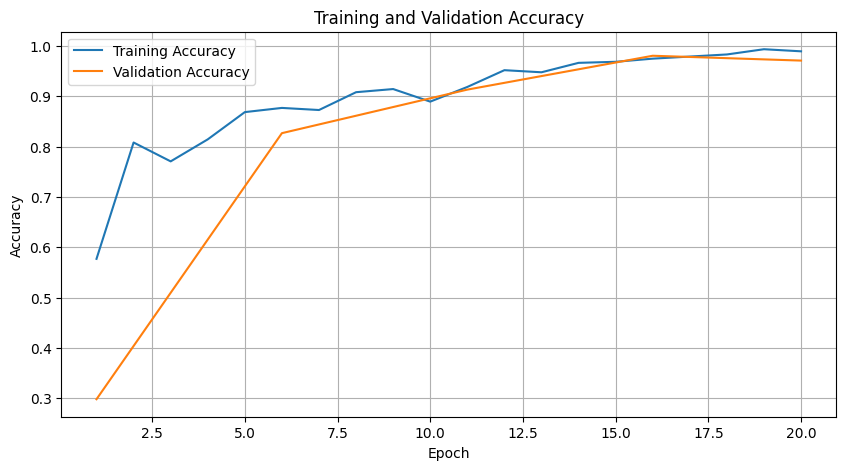

In [10]:
# Обучение модели
train_model(resnet18_model, train_loader, val_loader, device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Loss: 1.4878, Accuracy: 0.4938
Data loading time per image: 0.0024 seconds
Inference time per image: 0.1691 seconds


  5%|▌         | 1/20 [00:36<11:30, 36.35s/it]

Validation Loss: 113.9907, Accuracy: 0.2115


 25%|██▌       | 5/20 [02:37<07:43, 30.88s/it]

Epoch 6/20, Loss: 0.2982, Accuracy: 0.8729
Data loading time per image: 0.0018 seconds
Inference time per image: 0.1609 seconds


 30%|███       | 6/20 [03:12<07:31, 32.23s/it]

Validation Loss: 0.4348, Accuracy: 0.8173


 50%|█████     | 10/20 [05:10<05:02, 30.23s/it]

Epoch 11/20, Loss: 0.1662, Accuracy: 0.9313
Data loading time per image: 0.0018 seconds
Inference time per image: 0.1598 seconds


 55%|█████▌    | 11/20 [05:46<04:46, 31.86s/it]

Validation Loss: 0.1999, Accuracy: 0.9135


 75%|███████▌  | 15/20 [07:51<02:37, 31.52s/it]

Epoch 16/20, Loss: 0.0903, Accuracy: 0.9667
Data loading time per image: 0.0018 seconds
Inference time per image: 0.1611 seconds


 80%|████████  | 16/20 [08:26<02:11, 32.83s/it]

Validation Loss: 0.1275, Accuracy: 0.9423


 95%|█████████▌| 19/20 [09:57<00:31, 31.02s/it]

Epoch 20/20, Loss: 0.0612, Accuracy: 0.9750
Data loading time per image: 0.0018 seconds
Inference time per image: 0.1605 seconds


100%|██████████| 20/20 [10:31<00:00, 31.57s/it]

Validation Loss: 0.0515, Accuracy: 0.9904


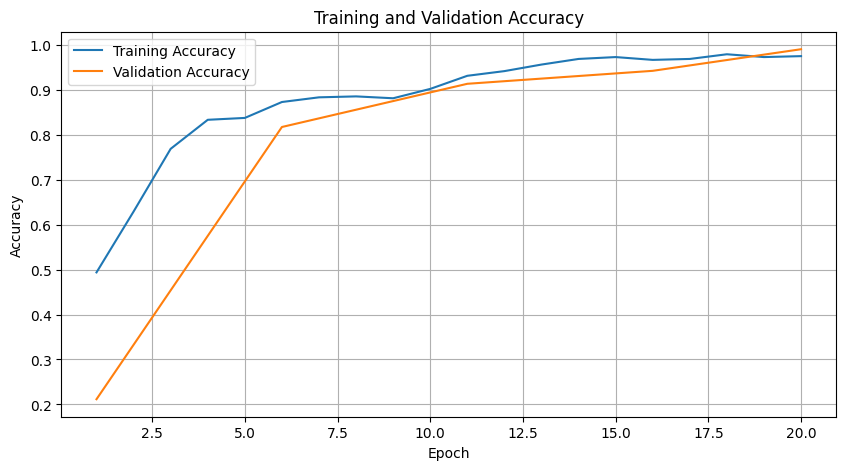

In [11]:
# Обучение модели
train_model(resnet34_model, train_loader, val_loader, device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Loss: 0.8286, Accuracy: 0.5896
Data loading time per image: 0.0018 seconds
Inference time per image: 0.1618 seconds


  5%|▌         | 1/20 [00:37<11:54, 37.62s/it]

Validation Loss: 1.0405, Accuracy: 0.6538


 25%|██▌       | 5/20 [02:36<07:34, 30.28s/it]

Epoch 6/20, Loss: 0.0813, Accuracy: 0.9792
Data loading time per image: 0.0017 seconds
Inference time per image: 0.1541 seconds


 30%|███       | 6/20 [03:10<07:22, 31.59s/it]

Validation Loss: 0.1164, Accuracy: 0.9615


 50%|█████     | 10/20 [05:09<05:00, 30.05s/it]

Epoch 11/20, Loss: 0.0200, Accuracy: 0.9938
Data loading time per image: 0.0018 seconds
Inference time per image: 0.1553 seconds


 55%|█████▌    | 11/20 [05:43<04:43, 31.47s/it]

Validation Loss: 0.0031, Accuracy: 1.0000


 75%|███████▌  | 15/20 [07:42<02:30, 30.14s/it]

Epoch 16/20, Loss: 0.0091, Accuracy: 0.9979
Data loading time per image: 0.0018 seconds
Inference time per image: 0.1549 seconds


 80%|████████  | 16/20 [08:18<02:07, 31.80s/it]

Validation Loss: 0.0015, Accuracy: 1.0000


 95%|█████████▌| 19/20 [09:48<00:30, 30.68s/it]

Epoch 20/20, Loss: 0.0043, Accuracy: 1.0000
Data loading time per image: 0.0017 seconds
Inference time per image: 0.1556 seconds


100%|██████████| 20/20 [10:23<00:00, 31.18s/it]

Validation Loss: 0.0132, Accuracy: 0.9904


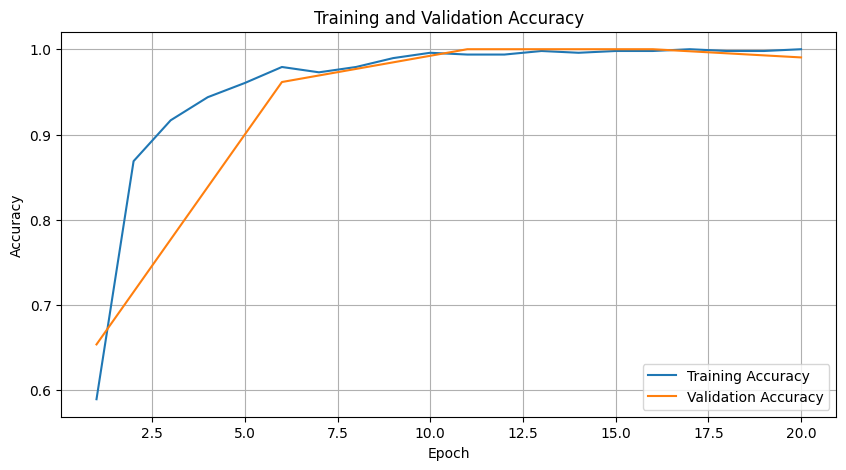

In [12]:
# Обучение модели
train_model(efficientnet_model, train_loader, val_loader, device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Loss: 0.6911, Accuracy: 0.6937
Data loading time per image: 0.0021 seconds
Inference time per image: 0.1028 seconds


  5%|▌         | 1/20 [00:32<10:18, 32.55s/it]

Validation Loss: 0.7013, Accuracy: 0.8173


 25%|██▌       | 5/20 [02:22<06:58, 27.90s/it]

Epoch 6/20, Loss: 0.1999, Accuracy: 0.9292
Data loading time per image: 0.0019 seconds
Inference time per image: 0.1014 seconds


 30%|███       | 6/20 [02:54<06:50, 29.33s/it]

Validation Loss: 0.2050, Accuracy: 0.9231


 50%|█████     | 10/20 [04:44<04:38, 27.80s/it]

Epoch 11/20, Loss: 0.0523, Accuracy: 0.9854
Data loading time per image: 0.0019 seconds
Inference time per image: 0.1018 seconds


 55%|█████▌    | 11/20 [05:17<04:23, 29.32s/it]

Validation Loss: 0.0567, Accuracy: 0.9712


 75%|███████▌  | 15/20 [07:05<02:18, 27.67s/it]

Epoch 16/20, Loss: 0.0159, Accuracy: 0.9917
Data loading time per image: 0.0019 seconds
Inference time per image: 0.0996 seconds


 80%|████████  | 16/20 [07:37<01:55, 28.96s/it]

Validation Loss: 0.0280, Accuracy: 0.9904


 95%|█████████▌| 19/20 [08:59<00:27, 27.92s/it]

Epoch 20/20, Loss: 0.0098, Accuracy: 0.9979
Data loading time per image: 0.0019 seconds
Inference time per image: 0.0999 seconds


100%|██████████| 20/20 [09:32<00:00, 28.62s/it]

Validation Loss: 0.0169, Accuracy: 0.9904


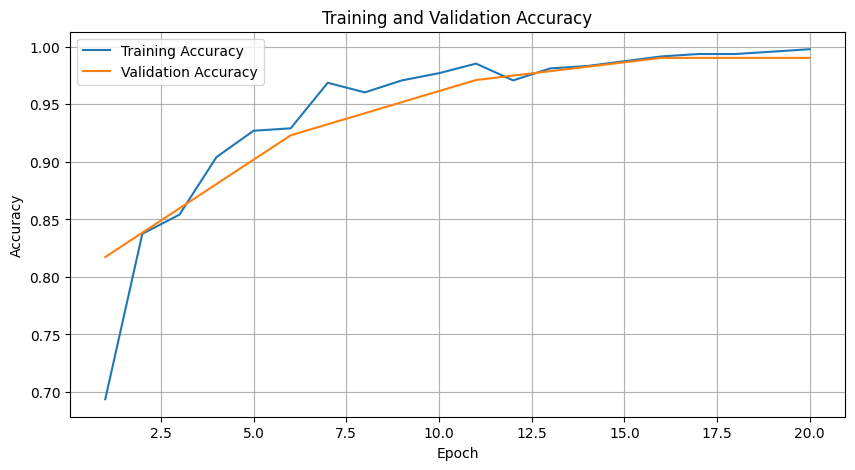

In [13]:
# Обучение модели
train_model(shufflenet_v2_model, train_loader, val_loader, device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Loss: 0.8975, Accuracy: 0.5500
Data loading time per image: 0.0020 seconds
Inference time per image: 0.1097 seconds


  5%|▌         | 1/20 [00:33<10:32, 33.31s/it]

Validation Loss: 9.3623, Accuracy: 0.3462


 25%|██▌       | 5/20 [02:23<06:58, 27.92s/it]

Epoch 6/20, Loss: 0.0983, Accuracy: 0.9583
Data loading time per image: 0.0019 seconds
Inference time per image: 0.0996 seconds


 30%|███       | 6/20 [02:55<06:51, 29.41s/it]

Validation Loss: 93.7937, Accuracy: 0.3462


 50%|█████     | 10/20 [04:46<04:39, 27.99s/it]

Epoch 11/20, Loss: 0.0180, Accuracy: 0.9938
Data loading time per image: 0.0019 seconds
Inference time per image: 0.1002 seconds


 55%|█████▌    | 11/20 [05:17<04:21, 29.09s/it]

Validation Loss: 2.0987, Accuracy: 0.8173


 75%|███████▌  | 15/20 [07:05<02:16, 27.38s/it]

Epoch 16/20, Loss: 0.0061, Accuracy: 0.9979
Data loading time per image: 0.0019 seconds
Inference time per image: 0.0993 seconds


 80%|████████  | 16/20 [07:37<01:54, 28.75s/it]

Validation Loss: 0.0544, Accuracy: 0.9712


 95%|█████████▌| 19/20 [08:58<00:27, 27.57s/it]

Epoch 20/20, Loss: 0.0032, Accuracy: 1.0000
Data loading time per image: 0.0019 seconds
Inference time per image: 0.0984 seconds


100%|██████████| 20/20 [09:30<00:00, 28.51s/it]

Validation Loss: 0.0134, Accuracy: 0.9904


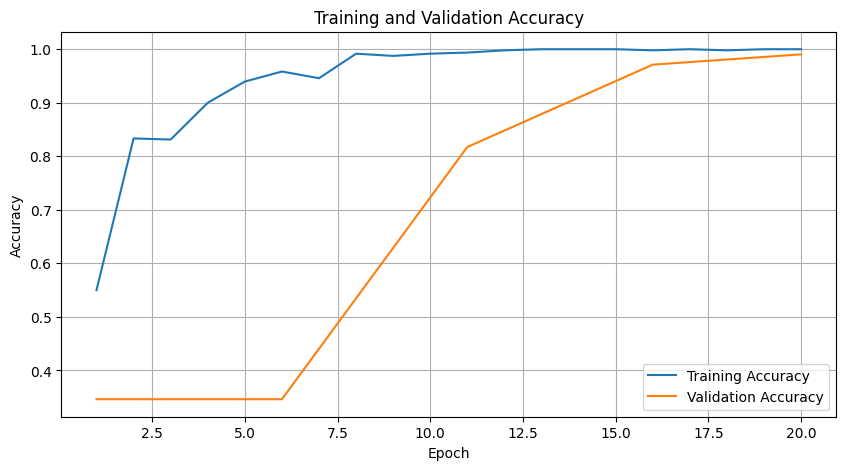

In [14]:
# Обучение модели
train_model(mobilenet_v3_model, train_loader, val_loader, device)

Модели отлично предсказывают класс ориентацию справки на фотографии, даже при обучении всего на 20 эпохах. 

Результаты моделей следующие:

**ResNet18:**
- Loss: 0.0301, Accuracy: 0.9896
- Inference time per image: 0.1055 seconds
- Validation Loss: 0.0733, Accuracy: 0.9712

**ResNet34:**
- Loss: 0.0612, Accuracy: 0.9750
- Inference time per image: 0.1605 seconds
- Validation Loss: 0.0515, Accuracy: 0.9904

**EfficientNet:**
- Loss: 0.0043, Accuracy: 1.0000
- Inference time per image: 0.1556 seconds
- Validation Loss: 0.0132, Accuracy: 0.9904

**ShuffleNet_V2:**
- Loss: 0.0098, Accuracy: 0.9979
- Inference time per image: 0.0999 seconds
- Validation Loss: 0.0169, Accuracy: 0.9904

**MobileNet_v3:**
- Loss: 0.0032, Accuracy: 1.0000
- Inference time per image: 0.0984 seconds
- Validation Loss: 0.0134, Accuracy: 0.9904

Все модели показали похожий результат, нету явных лидеров или отстающих. Принято решение выбрать сеть EfficientNet по совокупности показателей и вывода графика изменения метрики при обучении.

Проведем обучение модели на большом количестве эпох. Обучение займет длительное время, поэтому выполним вне отчета.

  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 1/120, Loss: 0.7715, Accuracy: 0.6708
Data loading time per image: 0.0020 seconds
Inference time per image: 0.1449 seconds


  1%|          | 1/120 [00:31<1:03:08, 31.84s/it]

Validation Loss: 0.7405, Accuracy: 0.7115


  4%|▍         | 5/120 [02:31<58:25, 30.48s/it]  

Epoch 6/120, Loss: 0.0817, Accuracy: 0.9667
Data loading time per image: 0.0018 seconds
Inference time per image: 0.1552 seconds


  5%|▌         | 6/120 [03:06<1:00:49, 32.01s/it]

Validation Loss: 0.1238, Accuracy: 0.9423


  8%|▊         | 10/120 [05:06<55:46, 30.42s/it] 

Epoch 11/120, Loss: 0.0755, Accuracy: 0.9812
Data loading time per image: 0.0018 seconds
Inference time per image: 0.1556 seconds


  9%|▉         | 11/120 [05:40<57:25, 31.61s/it]

Validation Loss: 0.1092, Accuracy: 0.9712


 12%|█▎        | 15/120 [07:40<53:48, 30.75s/it]

Epoch 16/120, Loss: 0.0484, Accuracy: 0.9833
Data loading time per image: 0.0018 seconds
Inference time per image: 0.1557 seconds


 13%|█▎        | 16/120 [08:17<56:16, 32.46s/it]

Validation Loss: 0.0180, Accuracy: 0.9904


 17%|█▋        | 20/120 [10:26<53:49, 32.30s/it]

Epoch 21/120, Loss: 0.0097, Accuracy: 0.9979
Data loading time per image: 0.0018 seconds
Inference time per image: 0.1584 seconds


 18%|█▊        | 21/120 [11:02<54:55, 33.29s/it]

Validation Loss: 0.0024, Accuracy: 1.0000


 21%|██        | 25/120 [13:05<49:54, 31.52s/it]

Epoch 26/120, Loss: 0.0272, Accuracy: 0.9917
Data loading time per image: 0.0017 seconds
Inference time per image: 0.1581 seconds


 22%|██▏       | 26/120 [13:41<51:27, 32.85s/it]

Validation Loss: 0.0140, Accuracy: 0.9904


 25%|██▌       | 30/120 [15:42<46:14, 30.83s/it]

Epoch 31/120, Loss: 0.0191, Accuracy: 0.9938
Data loading time per image: 0.0017 seconds
Inference time per image: 0.1580 seconds


 26%|██▌       | 31/120 [16:19<48:06, 32.43s/it]

Validation Loss: 0.0146, Accuracy: 0.9904


 29%|██▉       | 35/120 [18:25<45:13, 31.92s/it]

Epoch 36/120, Loss: 0.0046, Accuracy: 0.9979
Data loading time per image: 0.0017 seconds
Inference time per image: 0.1585 seconds


 30%|███       | 36/120 [19:02<46:34, 33.27s/it]

Validation Loss: 0.0013, Accuracy: 1.0000


 33%|███▎      | 40/120 [21:07<42:23, 31.79s/it]

Epoch 41/120, Loss: 0.0241, Accuracy: 0.9917
Data loading time per image: 0.0017 seconds
Inference time per image: 0.1593 seconds


 34%|███▍      | 41/120 [21:43<43:46, 33.25s/it]

Validation Loss: 0.1071, Accuracy: 0.9519


 38%|███▊      | 45/120 [23:43<38:09, 30.53s/it]

Epoch 46/120, Loss: 0.0123, Accuracy: 0.9958
Data loading time per image: 0.0017 seconds
Inference time per image: 0.1591 seconds


 38%|███▊      | 46/120 [24:18<39:14, 31.82s/it]

Validation Loss: 0.0052, Accuracy: 1.0000


 42%|████▏     | 50/120 [26:16<35:22, 30.33s/it]

Epoch 51/120, Loss: 0.0017, Accuracy: 1.0000
Data loading time per image: 0.0017 seconds
Inference time per image: 0.1587 seconds


 42%|████▎     | 51/120 [26:52<36:52, 32.06s/it]

Validation Loss: 0.0008, Accuracy: 1.0000


 46%|████▌     | 55/120 [28:57<33:40, 31.09s/it]

Epoch 56/120, Loss: 0.0027, Accuracy: 0.9979
Data loading time per image: 0.0017 seconds
Inference time per image: 0.1591 seconds


 47%|████▋     | 56/120 [29:33<34:42, 32.54s/it]

Validation Loss: 0.0043, Accuracy: 1.0000


 50%|█████     | 60/120 [31:40<31:57, 31.96s/it]

Epoch 61/120, Loss: 0.0007, Accuracy: 1.0000
Data loading time per image: 0.0017 seconds
Inference time per image: 0.1593 seconds


 51%|█████     | 61/120 [32:16<32:51, 33.42s/it]

Validation Loss: 0.0013, Accuracy: 1.0000


 54%|█████▍    | 65/120 [34:17<28:21, 30.93s/it]

Epoch 66/120, Loss: 0.0002, Accuracy: 1.0000
Data loading time per image: 0.0017 seconds
Inference time per image: 0.1591 seconds


 55%|█████▌    | 66/120 [34:51<28:51, 32.06s/it]

Validation Loss: 0.0001, Accuracy: 1.0000


 58%|█████▊    | 70/120 [36:51<25:16, 30.33s/it]

Epoch 71/120, Loss: 0.0001, Accuracy: 1.0000
Data loading time per image: 0.0017 seconds
Inference time per image: 0.1591 seconds


 59%|█████▉    | 71/120 [37:26<25:42, 31.48s/it]

Validation Loss: 0.0002, Accuracy: 1.0000


 62%|██████▎   | 75/120 [39:25<22:34, 30.11s/it]

Epoch 76/120, Loss: 0.0001, Accuracy: 1.0000
Data loading time per image: 0.0017 seconds
Inference time per image: 0.1591 seconds


 63%|██████▎   | 76/120 [40:00<23:09, 31.58s/it]

Validation Loss: 0.0000, Accuracy: 1.0000


 67%|██████▋   | 80/120 [41:59<20:08, 30.22s/it]

Epoch 81/120, Loss: 0.0002, Accuracy: 1.0000
Data loading time per image: 0.0017 seconds
Inference time per image: 0.1589 seconds


 68%|██████▊   | 81/120 [42:34<20:34, 31.65s/it]

Validation Loss: 0.0010, Accuracy: 1.0000


 71%|███████   | 85/120 [44:31<17:21, 29.75s/it]

Epoch 86/120, Loss: 0.0001, Accuracy: 1.0000
Data loading time per image: 0.0017 seconds
Inference time per image: 0.1587 seconds


 72%|███████▏  | 86/120 [45:05<17:43, 31.27s/it]

Validation Loss: 0.0009, Accuracy: 1.0000


 75%|███████▌  | 90/120 [47:05<15:04, 30.15s/it]

Epoch 91/120, Loss: 0.0006, Accuracy: 1.0000
Data loading time per image: 0.0017 seconds
Inference time per image: 0.1585 seconds


 76%|███████▌  | 91/120 [47:39<15:10, 31.39s/it]

Validation Loss: 0.0003, Accuracy: 1.0000


 79%|███████▉  | 95/120 [49:37<12:29, 29.97s/it]

Epoch 96/120, Loss: 0.0000, Accuracy: 1.0000
Data loading time per image: 0.0017 seconds
Inference time per image: 0.1585 seconds


 80%|████████  | 96/120 [50:12<12:30, 31.29s/it]

Validation Loss: 0.0000, Accuracy: 1.0000


 83%|████████▎ | 100/120 [52:10<09:58, 29.91s/it]

Epoch 101/120, Loss: 0.0001, Accuracy: 1.0000
Data loading time per image: 0.0017 seconds
Inference time per image: 0.1582 seconds


 84%|████████▍ | 101/120 [52:44<09:53, 31.24s/it]

Validation Loss: 0.0002, Accuracy: 1.0000


 88%|████████▊ | 105/120 [54:43<07:31, 30.11s/it]

Epoch 106/120, Loss: 0.0003, Accuracy: 1.0000
Data loading time per image: 0.0017 seconds
Inference time per image: 0.1579 seconds


 88%|████████▊ | 106/120 [55:18<07:22, 31.58s/it]

Validation Loss: 0.0000, Accuracy: 1.0000


 92%|█████████▏| 110/120 [57:18<05:04, 30.47s/it]

Epoch 111/120, Loss: 0.0002, Accuracy: 1.0000
Data loading time per image: 0.0017 seconds
Inference time per image: 0.1578 seconds


 92%|█████████▎| 111/120 [57:53<04:46, 31.87s/it]

Validation Loss: 0.0001, Accuracy: 1.0000


 96%|█████████▌| 115/120 [59:51<02:30, 30.00s/it]

Epoch 116/120, Loss: 0.0001, Accuracy: 1.0000
Data loading time per image: 0.0017 seconds
Inference time per image: 0.1577 seconds


 97%|█████████▋| 116/120 [1:00:25<02:05, 31.36s/it]

Validation Loss: 0.0002, Accuracy: 1.0000


 99%|█████████▉| 119/120 [1:01:55<00:30, 30.32s/it]

Epoch 120/120, Loss: 0.0000, Accuracy: 1.0000
Data loading time per image: 0.0017 seconds
Inference time per image: 0.1577 seconds


100%|██████████| 120/120 [1:02:31<00:00, 31.27s/it]

Validation Loss: 0.0006, Accuracy: 1.0000


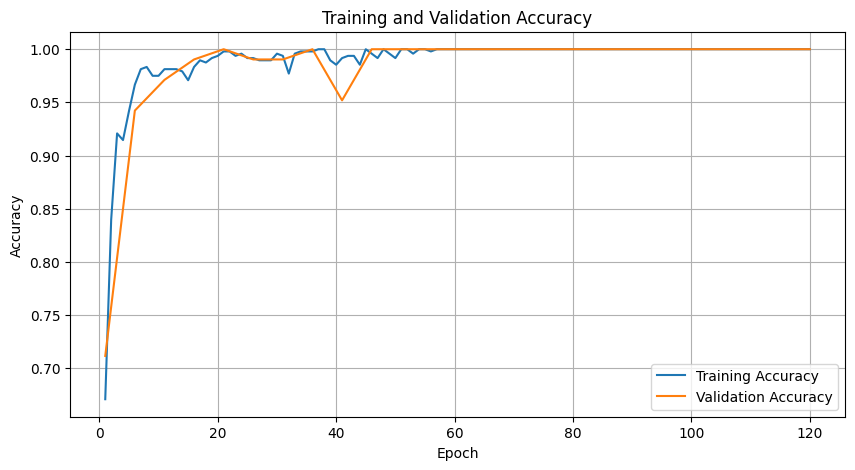

In [17]:
train_model(efficientnet_model, train_loader, val_loader, device, num_epochs=120)

Сохраняем обученную модель в файл. Это пригодится для загрузки модели в микросервисе на docker.

In [18]:
# Сохранение обученной модели
torch.save(efficientnet_model.state_dict(), 'rotation_efnet_classifier.pth')

**Вывод:**
Подготовлены скрипты обучения нейросетей. Данные поступают в модели с помощью DataLoader, тензоры соединены в пачки по 32.Выбраны оптимизатор Адам, планировщик градиентного шага - CosineAnnealingLR, функция потерь - CrossEntropyLoss.

На валидационных данных проверены исследуемые модели нейронных сетей. Все нейронные сети показали хороший результат. По совокупности результатов валидации выбрана EfficientNet. Проведено обучение на 120 эпохах, что заняло около часа времени.

## Тестирование лучшей модели

Этап тестирования модели отличается от валидации. После тестирования модели необходимо построить матрицу спутанности и кривую ROC-AUC. Для того, чтобы выполнить это требование, в функции тестирования модели укажем на выходе массивы с действительными и предсказанными классами объектов, а так же вероятность класса.

Загрузим предобученную на большом количестве эпох модель и переведем в режим оценки.

In [ ]:
test_model = get_efficientnet_model()
test_model.load_state_dict(torch.load('rotation_efnet_classifier.pth'))
test_model.to(device)
test_model.eval()

Выполним скрипт предсказания модели на тестовой выборке. Этот скрипт отличается тем, что на выходе функции получаем массивы со всеми правильными ответами, предсказаниями модели и вероятностями. Благодаря этому можно построить матрицу спутанности и кривую ROC-AUC.

In [29]:
testing_model(test_model, test_loader, device='cuda:0')

Validation Loss: 0.0000, Accuracy: 1.0000
Data loading time: 0.0022 seconds
Inference time: 6.0021 seconds


(array([2, 1, 1, 0, 2, 0, 2, 1, 3, 1, 2, 2, 2, 2, 1, 0, 2, 0, 1, 2, 2, 1,
        3, 0, 3, 3, 0, 0, 3, 3, 2, 3, 3, 0, 2, 3, 3, 0, 3, 3, 2, 3, 2, 0,
        2, 1, 1, 1, 2, 3, 1, 0, 1, 1, 1, 1, 2, 1, 3, 2, 2, 2, 3, 1, 3, 0,
        3, 1, 3, 0, 0, 3, 0, 3, 2, 0, 2, 1, 1, 2, 0, 2, 3, 3, 0, 1, 0, 1,
        2, 0, 1, 1, 0, 2, 0, 3, 2, 2, 3, 3, 2, 3, 3, 2]),
 array([2, 1, 1, 0, 2, 0, 2, 1, 3, 1, 2, 2, 2, 2, 1, 0, 2, 0, 1, 2, 2, 1,
        3, 0, 3, 3, 0, 0, 3, 3, 2, 3, 3, 0, 2, 3, 3, 0, 3, 3, 2, 3, 2, 0,
        2, 1, 1, 1, 2, 3, 1, 0, 1, 1, 1, 1, 2, 1, 3, 2, 2, 2, 3, 1, 3, 0,
        3, 1, 3, 0, 0, 3, 0, 3, 2, 0, 2, 1, 1, 2, 0, 2, 3, 3, 0, 1, 0, 1,
        2, 0, 1, 1, 0, 2, 0, 3, 2, 2, 3, 3, 2, 3, 3, 2]),
 array([[3.76591869e-09, 2.97497443e-10, 1.00000000e+00, 2.28779651e-11],
        [2.50427523e-09, 9.99997020e-01, 6.65920425e-07, 2.28972954e-06],
        [2.16458032e-11, 1.00000000e+00, 2.76263523e-09, 4.90815344e-09],
        [1.00000000e+00, 1.07120571e-11, 6.95417821e-11, 3.47314510e-1

Напишем скрипты для отрисовки матрицы спутанности и кривой ROC-AUC.

In [25]:
def plot_confusion_matrix(y_true: np.array, y_pred: np.array):
    """
    Строит матрицу ошибок (confusion matrix) для истинных и предсказанных меток.

    :param y_true: array-like - истинные метки классов.
    :param y_pred: array-like - предсказанные моделью метки классов.
    
    :return: None - функция строит и отображает матрицу ошибок в виде тепловой карты.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 90, 180, 270], yticklabels=[0, 90, 180, 270])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def plot_multiclass_roc(y_true: np.array, y_score: np.array, num_classes: int, class_labels: list):
    """
    Строит ROC-AUC кривые для многоклассовой классификации на основе истинных меток и предсказанных вероятностей.

    :param y_true: np.array - массив истинных меток классов (целых чисел).
    :param y_score: np.array - массив предсказанных вероятностей для каждого класса (размерностью [num_samples, num_classes]).
    :param num_classes: int - количество классов для классификации.
    :param class_labels: list - список меток классов для отображения на графике.
    
    :return: None - функция строит и отображает ROC-AUC кривые для каждого класса.

    Пример работы:
    - Бинаризует истинные метки классов с помощью label_binarize.
    - Рассчитывает значения ROC-кривой (False Positive Rate и True Positive Rate) для каждого класса.
    - Вычисляет площадь под кривой (AUC) для каждого класса.
    - Строит и отображает ROC-AUC кривую для каждого класса с различными цветами, указывая AUC на графике.

    Вывод:
    - Отображает график ROC-AUC кривых для оценки качества модели в мультиклассовой классификации.
    """

    # Бинаризация меток классов
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
    
    # Инициализация словарей для хранения FPR, TPR и AUC для каждого класса
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Расчет ROC-кривых и AUC для каждого класса
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Построение ROC кривых для каждого класса
    plt.figure(figsize=(8, 6))
    colors = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {class_labels[i]} (AUC = {roc_auc[i]:.2f})')

    # Добавление линии случайного угадывания
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    # Настройки осей и графика
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve for Multiclass Classification')
    plt.legend(loc="lower right")
    plt.show()

Построим матрицу спутанности и кривую ROC_AUC.

Validation Loss: 0.0042, Accuracy: 1.0000
Data loading time: 0.0020 seconds
Inference time: 6.1500 seconds


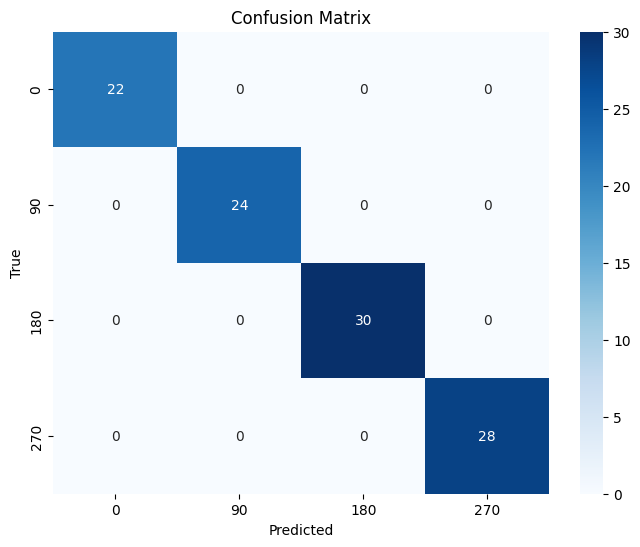

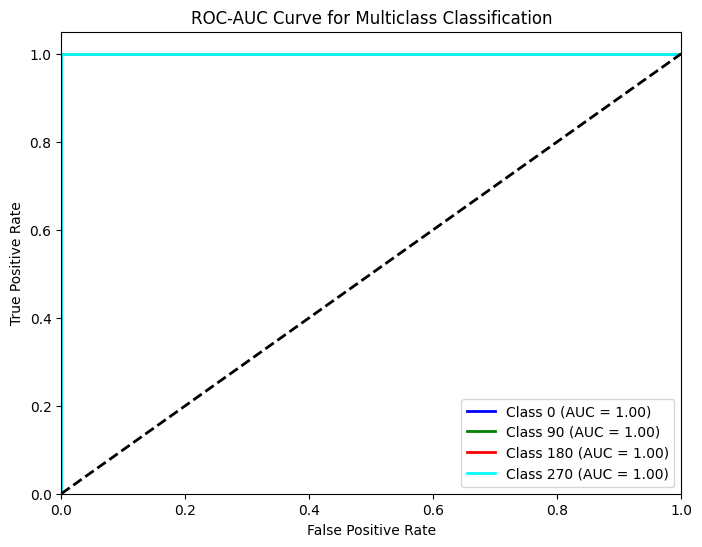

In [34]:
labels, predictions, probabilities = testing_model(test_model, test_loader, device)

# Построение матрицы спутанности
plot_confusion_matrix(labels, predictions)

# Построение ROC-AUC кривой
plot_multiclass_roc(labels, probabilities, num_classes=4, class_labels=[0, 90, 180, 270])

Модель предсказала все классы верно, поэтому площадь под кривой равна 1.